In [1]:
import numpy as np
from mouselabdiscrete import NewMouselabEnv
from evaluation import *
from distributions import PiecewiseUniform, expectation
from time import time

from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count() - 1

import pandas as pd

/home/amehta/virtualenvs/mouselab/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import pickle

participant_id = 4
stock_id = 0

biased_file_name = "bias_dists/t_posteriors_" + str(participant_id) + '.pkl'
csv_file_name = "bias_rewards/" + 'bmpsupdates' + str(participant_id) + '_' + str(stock_id) + '.csv'


num_trials = 50

biased_observations = np.array(pickle.load(open(biased_file_name, 'rb'))[stock_id])*num_trials
biased_observations = biased_observations.astype(int)

params_list = []
for i in range(47):
    params_file_name = "indiv_uws_fits_dist/params_" + str(i) + '.pkl'
    bm_params = pickle.load(open(params_file_name, 'rb'))[0]
    params_list.append(bm_params)
    
len_params_list = len(params_list)

In [3]:
import scipy.stats
from scipy.stats import dirichlet


gambles = 7
attributes = 4
alpha = 0.15 #dispersion
num_episodes = 10
num_test_episodes = 5
cost=2

prior_alphas = np.array([ 2.04384224,  1.25739246,  2.25103129,  5.28486598, 14.49720341,
       25.89638925, 13.8111208 ,  2.90207659,  0.95780393,  0.95166241])

intervals = [(-100,-80),(-80,-60),(-60,-40),(-40,-20),(-20,0),(0,20),(20,40),(40,60),(60,80),(80,100)]

mhmcmc_iters = 100000

# Metropolis-Hastings MCMC

In [4]:
epsilon = 0.0001

bins = [(-1, -0.8),
 (-0.8, -0.6),
 (-0.6, -0.4),
 (-0.4, -0.2),
 (-0.2, 0.0),
 (0.0, 0.2),
 (0.2, 0.4),
 (0.4, 0.6),
 (0.6, 0.8),
 (0.8, 1.0)]
bin_reps = [np.round(np.mean(b), 2) for b in bins]

def b_uws(observed_dist):
    x_bar = np.dot(observed_dist, bin_reps)
    x_b = np.abs(bin_reps - x_bar)
    temp = np.multiply(x_b, observed_dist)
    biased_probs = temp/temp.sum()
    return biased_probs

def b_under(observed_dist, k):
    biased_probs = np.array([p**abs(k*b) for p, b in zip(observed_dist, bin_reps)])
    biased_probs = biased_probs/biased_probs.sum()
    return biased_probs/biased_probs.sum()

def bias_model(observed_dist, bm_params):
    p1 = bm_params[0]
    p2 = bm_params[1]
    k = bm_params[2]
    biased_probs = (1-p1)*(1-p2)*observed_dist + p1*(1-p2)*b_uws(observed_dist) + (1-p1)*p2*(b_under(observed_dist, k)) + p1*p2*b_uws(b_under(observed_dist, k))
    return biased_probs

# def bias_model(probs):
#     p1 = bm_params[0]
#     p2 = bm_params[1]
#     k = bm_params[2]
#     k2 = bm_params[3]
#     p3 = 1-p1-p2
#     extreme_probs = np.array([p**(-abs(k*b)) for p, b in zip(probs, bin_reps)])
#     extreme_probs = extreme_probs/extreme_probs.sum()
    
#     forget_probs = np.array([p**abs(k2*b) for p, b in zip(probs, bin_reps)])
#     forget_probs = forget_probs/forget_probs.sum()
    
#     mixture_probs = p1*np.array(probs) + p2*extreme_probs + p3*forget_probs
#     mixture_probs[mixture_probs == 0] = epsilon
    
#     return mixture_probs/mixture_probs.sum()

def dirichlet_proposal(x, scale = 20):
    #qxx = 1
    xnew = dirichlet.rvs(x*scale)[0]
    xnew[xnew == 0.0] = epsilon
    xnew /= np.sum(xnew)
    
    pnew = dirichlet.logpdf(xnew, alpha = x*scale)
    pold = dirichlet.logpdf(x, alpha = xnew*scale)
    qxx = np.exp(pold - pnew)
    #x[x == 0] = epsilon
    #x += x*epsilon
    #return (scipy.stats.dirichlet.rvs((x + epsilon)*scale)[0], qxx)
    return (xnew, qxx)
    
def dirichlet_multinomial(x):
    logprior = dirichlet.logpdf(x, alpha = prior_alphas)
    
    likelihood = 0
    for i in range(len_params_list):
        biased_probs = bias_model(x, params_list[i])
        par_like = scipy.stats.multinomial.pmf(biased_observations, n = num_trials, p = biased_probs)
        likelihood += par_like
    
    likelihood = likelihood/len_params_list
    
    loglikelihood = np.log(likelihood)
    
    return loglikelihood + logprior


In [5]:
def mh_sampler(x0, post_fn, prop_fn, prop_fn_kwargs={}, iterations=100000):
    """Simple metropolis hastings sampler.
    
    :param x0: Initial array of parameters.
    :param post_fn: Function to compute posterior.
    :param prop_fn: Function to perform jumps.
    :param prop_fn_kwargs: Keyword arguments for proposal function
    :param iterations: Number of iterations to run sampler. Default=100000
    
    :returns: 
        (chain, acceptance, lnprob) tuple of parameter chain , acceptance rate 
        and log-posterior chain.
    """
    
    # number of dimensions
    ndim = len(x0)
    
    # initialize chain, acceptance rate and lnprob
    chain = np.zeros((iterations, ndim))
    lnprob = np.zeros(iterations)
    accept_rate = np.zeros(iterations)
    
    # first samples
    chain[0] = x0
    lnprob0 = post_fn(x0)
    lnprob[0] = lnprob0
    
    # start loop
    naccept = 0
    for ii in range(1, iterations):
        
        # propose
        x_star, factor = prop_fn(x0, **prop_fn_kwargs)
        
        # draw random uniform number
        u = np.random.uniform(0, 1)
        
        # compute hastings ratio
        lnprob_star = post_fn(x_star)
        H = np.exp(lnprob_star - lnprob0) * factor
        
        # accept/reject step (update acceptance counter)
        if u < H:
            x0 = x_star
            lnprob0 = lnprob_star
            naccept += 1
        
        # update chain
        chain[ii] = x0
        lnprob[ii] = lnprob0
        accept_rate[ii] = naccept / ii
        
    return chain, accept_rate, lnprob

In [12]:
import dirichlet as dlt

np.random.seed(10)

#start the mhmcmc chain by the biased observations (+1 so that all bins have non-zero probabilities)
x0 = biased_observations + 1
x0 = x0/np.sum(x0)
chain, ar, lnprob = mh_sampler(x0, dirichlet_multinomial, dirichlet_proposal, 
                                        prop_fn_kwargs={'scale': 250}, iterations = mhmcmc_iters)
#Discard initial samples
burn = int(0.1 * chain.shape[0])
mhmcmc_samples = chain[burn:].copy()

#shuffle the rest of the samples
np.random.shuffle(mhmcmc_samples)

#Use samples for the train and test envs
train_prob_list = mhmcmc_samples[:num_episodes]
test_prob_list = mhmcmc_samples[num_episodes:num_episodes + num_test_episodes]

#Use a dirichlet approx for the posterior distribution
posterior_alphas = dlt.mle(mhmcmc_samples[num_episodes + num_test_episodes:], tol=1e-7, method="fixedpoint")

In [13]:
ar[-1]

0.21171211712117122

In [14]:
posterior_alphas

array([ 1.575,  1.497,  2.726,  5.188, 15.3  , 29.574, 17.19 ,  3.64 ,  2.192,  0.735])

# BMPS

In [33]:
probabilities = dirichlet.mean(posterior_alphas)

reward = PiecewiseUniform(intervals, probabilities)

In [34]:
def update_alphas(alphas, observed_value):
    for i in range(len(intervals)):
        low = intervals[i][0]
        high = intervals[i][1]
        if low <= observed_value and high > observed_value:
            alphas[i] += 1
            return alphas


def update_state(state, reward):
    dists = state[1]
    newstate = []
    for dist in dists:
        if hasattr(dist, 'sample'):
            newstate.append(reward)
        else:
            newstate.append(dist)
    
    #state[1] = newstate
    return (state[0], newstate)

In [35]:
env_array = []

def make_train_envs(num_episodes = num_episodes):
    np.random.seed(1000)
    for i in range(num_episodes):
        true_probs = train_prob_list[i]
        truereward = PiecewiseUniform(intervals, true_probs)
        
        env = NewMouselabEnv(gambles, attributes, reward, cost, ground_truth_dist = truereward, alpha = alpha, sample_term_reward = True)
        env_array.append(env)

make_train_envs()        
        

def blackboxfunc(W, num_episodes = num_episodes):
    
    w1 = W[:,0]
    w2 = W[:,1]
    w4 = W[:,2]
    
    cumreturn = 0
    
    
    
    def run_episode(env):
        def voc_estimate(x):
            features = env.action_features(x)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            w3 = 1 - w1 - w2
            return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]

#    for i in range(num_episodes):
#        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=0.15)
        trial_alphas = posterior_alphas
        exp_return = 0

        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _= env._step(action_taken)
            exp_return+=rew
            if done:
                env._reset()
                break
                
            if action_taken>=attributes:
                observed_value = env._state[1][action_taken - attributes]
                trial_alphas = update_alphas(trial_alphas, observed_value)
                updated_probs = dirichlet.mean(trial_alphas)
                updated_reward = PiecewiseUniform(intervals, updated_probs)
                env._state = update_state(env._state, updated_reward)
                gambs = env.gamble_dists()
                env.mus = [expectation(g) for g in gambs]
                env.gdists = gambs
                
        return exp_return
        #print(exp_return)
        
    returns = Parallel(n_jobs=num_cores)(delayed(run_episode)(env) for env in env_array)
    
    cumreturn = sum(returns)
    
    print(cumreturn/num_episodes)
    return -cumreturn/num_episodes

In [36]:
import GPyOpt
import GPy


In [37]:
#pbounds = {'w1': (0,1), 'w2': (0,1), 'w3': (0,1), 'w4':(1,12)}
space = [{'name': 'w1', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'w2', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'w4', 'type': 'continuous', 'domain': (1,32)}]

In [38]:
constraints = [{'name': 'part_1', 'constraint': 'x[:,0] + x[:,1] - 1'}]

In [39]:
feasible_region = GPyOpt.Design_space(space = space, constraints = constraints)

In [40]:
# --- CHOOSE the intial design
from numpy.random import seed # fixed seed
seed(123456)

initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

In [41]:
# --- CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(blackboxfunc)

# --- CHOOSE the model type
#This model does Maximum likelihood estimation of the hyper-parameters.
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

# --- CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

# --- CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [42]:
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [43]:
# --- Stop conditions
max_time  = 60000 
tolerance = 1e-4    # distance between two consecutive observations  

In [44]:
# Run the optimization  
traint1 = time()
max_iter = 10
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=True) 
traint2 = time()

10.384179447582385
10.384179447582385
19.810501015147757
10.384179447582385
10.384179447582385
10.384179447582385
10.384179447582385
20.896354223040483
10.384179447582385
10.384179447582385
10.384179447582385
num acquisition: 1, time elapsed: 6.47s
20.49635422304048
num acquisition: 2, time elapsed: 35.72s
10.384179447582385
num acquisition: 3, time elapsed: 42.74s
19.928428190675582
num acquisition: 4, time elapsed: 71.70s
21.128428190675585
num acquisition: 5, time elapsed: 96.89s
21.096354223040482
num acquisition: 6, time elapsed: 123.78s
19.728428190675583
num acquisition: 7, time elapsed: 157.31s
20.601112544576118
num acquisition: 8, time elapsed: 192.71s
20.40111254457612
num acquisition: 9, time elapsed: 227.48s
18.854544508161126
num acquisition: 10, time elapsed: 263.64s


In [45]:
traint2 - traint1

382.5608763694763

In [46]:
bo.x_opt

array([0.391, 0.111, 3.978])

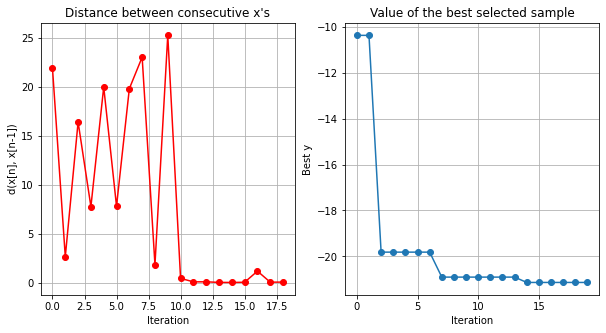

In [47]:
bo.plot_acquisition()
bo.plot_convergence()

In [48]:
optimal_weights = bo.x_opt
#optimal_weights = np.array([0.229, 0.32 , 2.888])

In [49]:
test_env_array = []

def make_test_envs(num_test_episodes = num_test_episodes):
    np.random.seed(100)
    for i in range(num_test_episodes):
        test_probs = test_prob_list[i]
        testreward = PiecewiseUniform(intervals, test_probs)
        
        env = NewMouselabEnv(gambles, attributes, reward, cost, ground_truth_dist = testreward, alpha = alpha, sample_term_reward = True)
        test_env_array.append(env)

make_test_envs()   

def testfunc(W, num_test_episodes = num_test_episodes):
    
    w1 = W[:,0]
    w2 = W[:,1]
    w4 = W[:,2]
    
    def run_episode(env):
        def voc_estimate(x):
            features = env.action_features(x)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            w3 = 1 - w1 - w2
            return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]

    #for env in test_env_array:
        #print(env.ground_truth)
        env._reset()
        exp_return = 0
        trial_alphas = posterior_alphas
        action_list = []
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)
            
            #print(action_taken)
            #if action_taken == env.term_action:
                #print(env._state)
                #print(env.grid())
            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew

            if done:
                #unopened += len(possible_actions) - 1 
                break
            
            action_list.append(action_taken)
            
            if action_taken>=attributes:
                observed_value = env._state[1][action_taken - attributes]
                trial_alphas = update_alphas(trial_alphas, observed_value)
                updated_probs = dirichlet.mean(trial_alphas)
                updated_reward = PiecewiseUniform(intervals, updated_probs)
                env._state = update_state(env._state, updated_reward)
                gambs = env.gamble_dists()
                env.mus = [expectation(g) for g in gambs]
                env.gdists = gambs
                
        return (list(env.ground_truth), list(env.distRV.ground_truth), exp_return, action_list, np.argmax(env.mus))
                 
    info_list = Parallel(n_jobs=num_cores)(delayed(run_episode)(env) for env in test_env_array)
    
    df = pd.DataFrame(info_list, columns = ['payoffs', 'probabilities', 'return', 'actions', 'gamble_taken'])
    
    cumreturn = np.sum(df['return'])
    #print(exp_return)
    #avgclicks = (gambles + 1)*attributes - unopened/num_test_episodes
    #print(avgclicks)
    print(cumreturn/num_test_episodes)
    df.to_csv(csv_file_name, index = False)
    #np.save(reward_file_name, reward_list)
    return -cumreturn/num_test_episodes

In [50]:
testt1 = time()
testfunc(np.array([optimal_weights]))
testt2 = time()

15.699098579562541


In [51]:
testt2 - testt1

20.382444143295288

In [52]:
posterior_alphas

array([ 1.303,  1.66 ,  2.411,  5.063, 17.104, 27.533, 17.521,  4.272,  1.894,  0.705])